In [1]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import to_categorical
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import load_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data_dir = 'dataset-ajustado/train'  
validation_data_dir = 'dataset-ajustado/valid'

In [6]:
width_shape = 224
height_shape = 224
batch_size = 32

In [7]:
# Definir el generador de imágenes para el conjunto de entrenamiento con aumentos de datos
train_datagen = ImageDataGenerator(  
    rotation_range=20,               # Rango de grados para rotación aleatoria
    zoom_range=0.2,                  # Rango de zoom aleatorio
    width_shift_range=0.1,           # Rango de desplazamiento horizontal aleatorio
    height_shift_range=0.1,          # Rango de desplazamiento vertical aleatorio
    horizontal_flip=True,            # Volteo horizontal aleatorio
    vertical_flip=False,             # No se aplica volteo vertical
    preprocessing_function=preprocess_input)  # Función de preprocesamiento

# Definir el generador de imágenes para el conjunto de validación con los mismos aumentos de datos
valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

# Crear un generador de lotes de imágenes para el conjunto de entrenamiento
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,                  # Directorio que contiene las imágenes de entrenamiento
    target_size=(width_shape, height_shape),  # Tamaño al que se redimensionarán las imágenes
    batch_size=batch_size,           # Tamaño del lote
    class_mode='categorical')        # Modo de clasificación para imágenes categóricas

# Crear un generador de lotes de imágenes para el conjunto de validación
validation_generator = valid_datagen.flow_from_directory(  
    validation_data_dir,             # Directorio que contiene las imágenes de validación
    target_size=(width_shape, height_shape),  # Tamaño al que se redimensionarán las imágenes
    batch_size=batch_size,           # Tamaño del lote
    class_mode='categorical')        # Modo de clasificación para imágenes categóricas


Found 21786 images belonging to 44 classes.
Found 6225 images belonging to 44 classes.


In [8]:
# Definir el número de muestras de entrenamiento y validación
nb_train_samples = 21786 
nb_validation_samples = 6225 
num_classes = 44  # Cambia este valor según el número de clases en tu conjunto de datos
epochs = 50  # Cambia este valor según tus necesidades

# Definir la entrada de la red neuronal con el tamaño de las imágenes
image_input = Input(shape=(width_shape, height_shape, 3))

# Cargar el modelo VGG16 preentrenado con pesos ajustados desde ImageNet
model = VGG16(input_tensor=image_input, include_top=True, weights='imagenet')

# Obtener la salida de la penúltima capa densa del modelo VGG16 (fc2)
last_layer = model.get_layer('fc2').output

# Añadir una nueva capa densa al final del modelo para la clasificación multiclase con regularización L2 (Evita sobreajuste)
out = Dense(num_classes, activation='softmax', kernel_regularizer='l2', name='output')(last_layer)

# Crear un nuevo modelo personalizado que toma la entrada de la imagen y produce la salida clasificada
custom_vgg_model = Model(image_input, out)

# Congelar todas las capas del modelo, excepto la capa densa añadida
for layer in custom_vgg_model.layers[:-1]:
    layer.trainable = False

# Compilar el modelo con una función de pérdida, optimizador y métricas especificadas
custom_vgg_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])


# Mostrar un resumen del modelo que incluye la arquitectura y el número de parámetros
custom_vgg_model.summary()

# Entrenar el modelo utilizando generadores de datos para el conjunto de entrenamiento y validación
model_history = custom_vgg_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    steps_per_epoch=nb_train_samples//batch_size,  # Número de pasos por época de entrenamiento
    validation_steps=nb_validation_samples//batch_size)  # Número de pasos por época de validación


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,440,812 (512.85 MB)

 Trainable params: 180,268 (704.17 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Epoch 1/50


C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


680/680 ━━━━━━━━━━━━━━━━━━━━ 4457s 7s/step - accuracy: 0.3021 - loss: 3.5772 - val_accuracy: 0.5475 - val_loss: 2.2975
Epoch 2/50
  1/680 ━━━━━━━━━━━━━━━━━━━━ 50:01 4s/step - accuracy: 0.5000 - loss: 2.2459

C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5000 - loss: 2.2459 - val_accuracy: 0.3529 - val_loss: 3.1490
Epoch 3/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 4091s 6s/step - accuracy: 0.5853 - loss: 2.1438 - val_accuracy: 0.6092 - val_loss: 1.9733
Epoch 4/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5938 - loss: 2.1871 - val_accuracy: 0.5294 - val_loss: 2.5659
Epoch 5/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 4100s 6s/step - accuracy: 0.6373 - loss: 1.8497 - val_accuracy: 0.6498 - val_loss: 1.7639
Epoch 6/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6562 - loss: 1.8878 - val_accuracy: 0.8235 - val_loss: 1.2747
Epoch 7/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 4079s 6s/step - accuracy: 0.6652 - loss: 1.6759 - val_accuracy: 0.6532 - val_loss: 1.6802
Epoch 8/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.6250 - loss: 1.8720 - val_accuracy: 0.7647 - val_loss: 1.5188
Epoch 9/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 4079s 6s/step - accuracy: 0.6909 - loss: 1.5527 - val_accuracy: 0.6

In [11]:
import os

# Nombre base del modelo
model_name = "model_VGG16_v"

# Extensión del archivo
file_extension = ".keras"

# Directorio donde se guardarán los modelos
model_directory = "models/"

# Inicializar contador
counter = 1

# Generar el nombre completo del archivo
file_name = model_name + file_extension

ruta=model_directory + file_name
print(ruta)
# Verificar si el modelo ya está guardado
while os.path.exists(model_directory + file_name):
    
    # Si el archivo existe, agregar un número al final del nombre del modelo
    file_name = f"{model_name}{counter}{file_extension}"
    counter += 1

# Guardar el modelo con el nombre único en el directorio correcto
custom_vgg_model.save(model_directory + file_name)

models/model_VGG16_v.keras


In [12]:
def plotTraining(hist, epochs, typeData):

    # Seleccionar la figura y establecer el tamaño
    # Dependiendo del tipo de datos (loss o accuracy), se elige la figura correspondiente
    
    if typeData=="loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'-r',label='Loss Training')
    if typeData=="accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'-r',label='Accuracy Training')
    if typeData=="val_loss":
        plt.figure(1,figsize=(10,5))
        yc=hist.history['val_loss']
        xc=range(epochs)
        plt.ylabel('Loss', fontsize=24)
        plt.plot(xc,yc,'--b',label='Loss Validate')
    if typeData=="val_accuracy":
        plt.figure(2,figsize=(10,5))
        yc=hist.history['val_accuracy']
        for i in range(0, len(yc)):
            yc[i]=100*yc[i]
        xc=range(epochs)
        plt.ylabel('Accuracy (%)', fontsize=24)
        plt.plot(xc,yc,'--b',label='Training Validate')
        

    plt.rc('xtick',labelsize=24)
    plt.rc('ytick',labelsize=24)
    plt.rc('legend', fontsize=18) 
    plt.legend()
    plt.xlabel('Number of Epochs',fontsize=24)
    plt.grid(True)


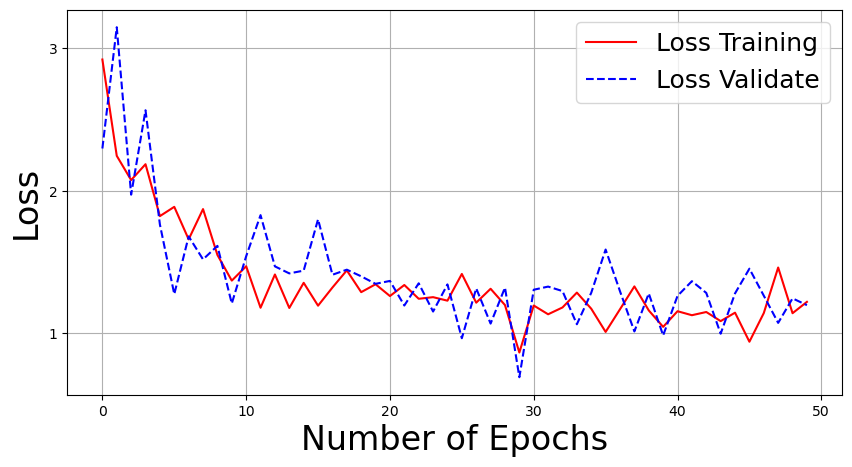

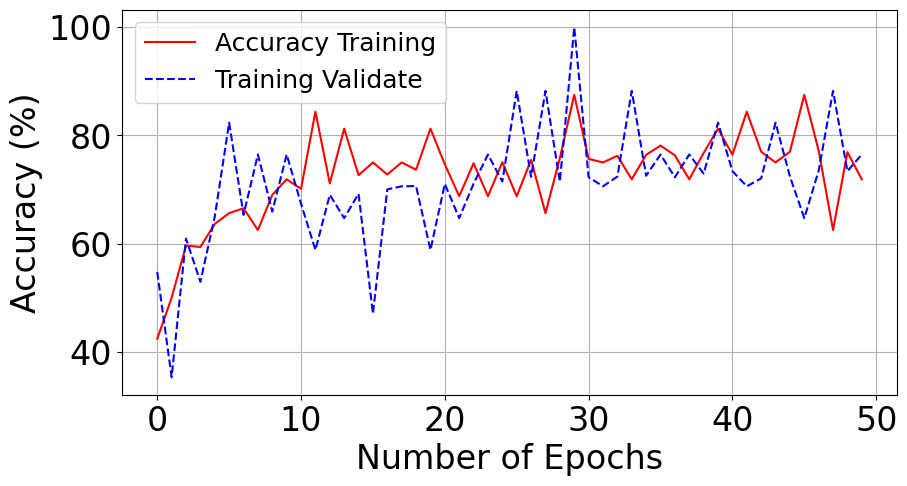

In [13]:
plotTraining(model_history,epochs,"loss")
plotTraining(model_history,epochs,"accuracy")
plotTraining(model_history,epochs,"val_loss")
plotTraining(model_history,epochs,"val_accuracy")

In [14]:
ruta = r"dataset-ajustado\train"

# Obteniendo los nombres de las carpetas y almacenándolos en una lista
names = [nombre for nombre in os.listdir(ruta) if os.path.isdir(os.path.join(ruta, nombre))]


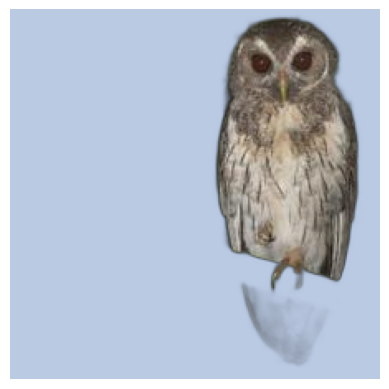

In [16]:
# Ruta de la imagen
imaget_path = r"dataset-ajustado\test\buho cafe\fillbgnobg_resize_Buho Cafe-218.png"

# Leer la imagen con OpenCV - la imagen es de buho cafe 
imagen = cv2.imread(imaget_path)

# Convertir de BGR a RGB para mostrarla correctamente con matplotlib
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

# Mostrar la imagen con matplotlib
plt.imshow(imagen_rgb)
plt.axis('off')  # Ocultar ejes
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
Clase predicha: Accipiter sp
Porcentaje de confianza: 22.21%


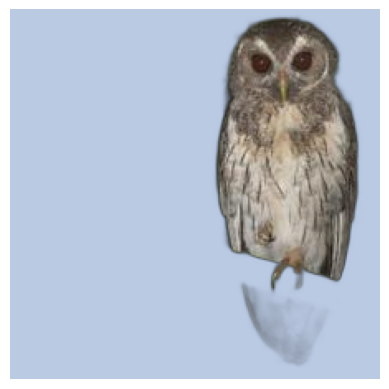

In [18]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model


# Cargar el modelo
modelt = load_model('models/model_VGG16_v.keras')
#modelt = custom_vgg_model

# Ruta de la imagen de prueba
#imaget_path = "ImagenPrueba_sin_fondo.jpg"

# Leer la imagen, cambiar tamaño y preprocesar
imaget=cv2.resize(cv2.imread(imaget_path), (width_shape, height_shape), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)

# Obtener las predicciones del modelo
preds = modelt.predict(xt)

# Obtener la clase predicha y su porcentaje de confianza
predicted_class_index = np.argmax(preds)
predicted_class_name = names[predicted_class_index]
confidence_percentage = preds[0][predicted_class_index] * 100

# Imprimir el resultado
print(f'Clase predicha: {predicted_class_name}')
print(f'Porcentaje de confianza: {confidence_percentage:.2f}%')

# Mostrar la imagen
plt.imshow(cv2.cvtColor(np.asarray(imaget), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [21]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

test_data_dir = 'dataset-ajustado/test'  

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_shape, height_shape), 
    batch_size = batch_size,
    class_mode='categorical', 
    shuffle=False)

custom_Model= load_model(model_directory + file_name)

predictions = custom_Model.predict(test_generator)


y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes


matc=confusion_matrix(y_real, y_pred)



print(metrics.classification_report(y_real,y_pred, digits = 4))

Found 3113 images belonging to 44 classes.
98/98 ━━━━━━━━━━━━━━━━━━━━ 461s 5s/step
              precision    recall  f1-score   support

           0     0.1053    0.3556    0.1624        45
           1     0.0545    0.0667    0.0600        45
           2     0.1000    0.1316    0.1136        38
           3     0.6522    0.2174    0.3261        69
           4     0.7037    0.4810    0.5714        79
           5     0.4062    0.2321    0.2955        56
           6     1.0000    0.0185    0.0364        54
           7     0.5000    0.0556    0.1000        18
           8     0.3171    0.2955    0.3059        44
           9     0.1915    0.5727    0.2870       110
          10     0.2381    0.1042    0.1449        48
          11     0.2609    0.2951    0.2769        61
          12     0.0000    0.0000    0.0000        53
          13     0.0000    0.0000    0.0000        25
          14     0.0000    0.0000    0.0000        41
          15     0.7027    0.4815    0.5714        5

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# todos los modelos

In [ ]:
# Importaciones necesarias
import time
import psutil
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir el número de muestras de entrenamiento y validación
nb_train_samples = 21786 
nb_validation_samples = 6225 

# Definir el número de épocas
epochs = 50

# Definir el tamaño de las imágenes
width_shape = 224
height_shape = 224

# Definir el número de clases
num_classes = 44  # Ajustar según el número de clases en tu dataset

# Directorios de datos de entrenamiento y validación
train_data_dir = 'dataset-ajustado/train'  
validation_data_dir = 'dataset-ajustado/valid'

# Función para crear y entrenar el modelo
def create_and_train_vgg16_model(learning_rate, l2_regularization, batch_size):
    # Crear generadores de datos con el batch_size proporcionado
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        preprocessing_function=preprocess_input
    )

    valid_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        preprocessing_function=preprocess_input
    )

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(width_shape, height_shape),
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = valid_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(width_shape, height_shape),
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Definir la entrada de la red neuronal con el tamaño de las imágenes
    image_input = Input(shape=(width_shape, height_shape, 3))

    # Cargar el modelo VGG16 preentrenado con pesos ajustados desde ImageNet
    model = VGG16(input_tensor=image_input, include_top=False, weights='imagenet')

    # Aplanar la salida del VGG16
    x = Flatten()(model.output)

    # Añadir una nueva capa densa al final del modelo para la clasificación multiclase con regularización L2
    out = Dense(num_classes, activation='softmax', kernel_regularizer='l2')(x)

    # Crear un nuevo modelo personalizado que toma la entrada de la imagen y produce la salida clasificada
    custom_vgg_model = Model(inputs=model.input, outputs=out)

    # Congelar todas las capas del modelo base VGG16
    for layer in model.layers:
        layer.trainable = False

    # Compilar el modelo con una función de pérdida, optimizador y métricas especificadas
    custom_vgg_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    # Mostrar un resumen del modelo que incluye la arquitectura y el número de parámetros
    custom_vgg_model.summary()

    # Medir el tiempo y el uso de CPU/memoria antes de entrenar
    start_time = time.time()
    start_cpu = psutil.cpu_percent(interval=None)
    start_memory = psutil.virtual_memory().used

    # Crear los callbacks para Early Stopping y guardar el mejor modelo
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

    # Entrenar el modelo utilizando generadores de datos para el conjunto de entrenamiento y validación
    model_history = custom_vgg_model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=[checkpoint, early_stopping]
    )

    # Medir el tiempo y el uso de CPU/memoria después de entrenar
    end_time = time.time()
    end_cpu = psutil.cpu_percent(interval=None)
    end_memory = psutil.virtual_memory().used

    # Calcular métricas de tiempo y uso de recursos
    elapsed_time = end_time - start_time
    cpu_usage = end_cpu - start_cpu
    memory_usage = end_memory - start_memory

    print(f"Tiempo transcurrido para el entrenamiento: {elapsed_time} segundos")
    print(f"Uso de CPU durante el entrenamiento: {cpu_usage}%")
    print(f"Aumento en uso de memoria: {memory_usage / (1024 ** 3)} GB")

    return model_history, elapsed_time, cpu_usage, memory_usage

# Definir rangos de búsqueda para hiperparámetros
learning_rates = [0.0001, 0.0005, 0.001]
l2_regularizations = [0.01, 0.05, 0.1]
batch_sizes = [16, 32, 64]

# Variables para almacenar los mejores hiperparámetros y su rendimiento
best_val_accuracy = 0
best_hyperparams = {}

# Realizar la búsqueda de cuadrícula
for learning_rate in learning_rates:
    for l2_regularization in l2_regularizations:
        for batch_size in batch_sizes:
            # Crear y entrenar el modelo con los hiperparámetros actuales
            model_history, elapsed_time, cpu_usage, memory_usage = create_and_train_vgg16_model(learning_rate, l2_regularization, batch_size)
            
            # Obtener la mejor precisión de validación de esta combinación de hiperparámetros
            val_accuracy = np.max(model_history.history['val_accuracy'])
            
            # Imprimir los resultados
            print(f"Resultados para lr={learning_rate}, l2={l2_regularization}, batch_size={batch_size}:")
            print(f"Tiempo: {elapsed_time} segundos, CPU: {cpu_usage}%, Memoria: {memory_usage / (1024 ** 3)} GB")
            print(f"Precisión de validación: {val_accuracy}")
            
            # Actualizar los mejores hiperparámetros si la precisión de validación mejora
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_hyperparams = {
                    'learning_rate': learning_rate,
                    'l2_regularization': l2_regularization,
                    'batch_size': batch_size,
                    'val_accuracy': val_accuracy,
                    'elapsed_time': elapsed_time,
                    'cpu_usage': cpu_usage,
                    'memory_usage': memory_usage
                }

# Imprimir los mejores hiperparámetros y su rendimiento
print("Mejores hiperparámetros encontrados:")
print(best_hyperparams)



Found 21786 images belonging to 44 classes.
Found 6225 images belonging to 44 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 44)                  │       1,103,916 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50


C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1361/1361 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2841 - loss: 10.7899
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to best_model.keras
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 4099s 3s/step - accuracy: 0.2842 - loss: 10.7876 - val_accuracy: 0.5625 - val_loss: 5.3089
Epoch 2/50
   1/1361 ━━━━━━━━━━━━━━━━━━━━ 54:25 2s/step - accuracy: 0.4375 - loss: 6.2593

C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.56250 to 1.00000, saving model to best_model.keras
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4375 - loss: 6.2593 - val_accuracy: 1.0000 - val_loss: 0.5762
Epoch 3/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6019 - loss: 4.3792
Epoch 3: val_accuracy did not improve from 1.00000
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 4086s 3s/step - accuracy: 0.6019 - loss: 4.3790 - val_accuracy: 0.6313 - val_loss: 4.3283
Epoch 4/50
   1/1361 ━━━━━━━━━━━━━━━━━━━━ 56:15 2s/step - accuracy: 0.6875 - loss: 2.7679
Epoch 4: val_accuracy did not improve from 1.00000
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 3s 227us/step - accuracy: 0.6875 - loss: 2.7679 - val_accuracy: 0.0000e+00 - val_loss: 15.6407
Epoch 5/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6854 - loss: 3.3643
Epoch 5: val_accuracy did not improve from 1.00000
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 4090s 3s/step - accuracy: 0.6854 - loss: 3.3643 - val_accuracy: 0.6828 - val_loss: 3.7826
Epoch 

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 44)                  │       1,103,916 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2635 - loss: 11.2342
Epoch 1: val_accuracy improved from -inf to 0.51401, saving model to best_model.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 4093s 6s/step - accuracy: 0.2637 - loss: 11.2294 - val_accuracy: 0.5140 - val_loss: 5.4138
Epoch 2/50
  1/680 ━━━━━━━━━━━━━━━━━━━━ 55:52 5s/step - accuracy: 0.6562 - loss: 4.0401
Epoch 2: val_accuracy improved from 0.51401 to 0.76471, saving model to best_model.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6562 - loss: 4.0401 - val_accuracy: 0.7647 - val_loss: 2.7117
Epoch 3/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5854 - loss: 4.2428
Epoch 3: val_accuracy did not improve from 0.76471
680/680 ━━━━━━━━━━━━━━━━━━━━ 4084s 6s/step - accuracy: 0.5854 - loss: 4.2426 - val_accuracy: 0.6136 - val_loss: 4.0167
Epoch 4/50
  1/680 ━━━━━━━━━━━━━━━━━━━━ 51:17 5s/step - accuracy: 0.7812 - loss: 1.9253
Epoch 4: val_accuracy did not improve from 0.76471
680/680 ━━━━━━━━━━━━

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 44)                  │       1,103,916 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2186 - loss: 12.4357
Epoch 1: val_accuracy improved from -inf to 0.48357, saving model to best_model.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 4029s 12s/step - accuracy: 0.2190 - loss: 12.4252 - val_accuracy: 0.4836 - val_loss: 5.6891
Epoch 2/50
  1/340 ━━━━━━━━━━━━━━━━━━━━ 51:32 9s/step - accuracy: 0.5312 - loss: 4.8898
Epoch 2: val_accuracy improved from 0.48357 to 0.52941, saving model to best_model.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5312 - loss: 4.8898 - val_accuracy: 0.5294 - val_loss: 3.9195
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5395 - loss: 4.6863
Epoch 3: val_accuracy improved from 0.52941 to 0.58682, saving model to best_model.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 4020s 12s/step - accuracy: 0.5396 - loss: 4.6855 - val_accuracy: 0.5868 - val_loss: 4.2932
Epoch 4/50
  1/340 ━━━━━━━━━━━━━━━━━━━━ 52:39 9s/step - accuracy: 0.6250 - loss: 3.6276
Epoch 4: val_accuracy did not 

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 44)                  │       1,103,916 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2881 - loss: 10.6375
Epoch 1: val_accuracy improved from -inf to 0.55768, saving model to best_model.keras
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 4161s 3s/step - accuracy: 0.2882 - loss: 10.6353 - val_accuracy: 0.5577 - val_loss: 5.2007
Epoch 2/50
   1/1361 ━━━━━━━━━━━━━━━━━━━━ 50:43 2s/step - accuracy: 0.3750 - loss: 7.0659
Epoch 2: val_accuracy improved from 0.55768 to 1.00000, saving model to best_model.keras
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 3s 503us/step - accuracy: 0.3750 - loss: 7.0659 - val_accuracy: 1.0000 - val_loss: 0.5658
Epoch 3/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6110 - loss: 4.2019
Epoch 3: val_accuracy did not improve from 1.00000
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 4132s 3s/step - accuracy: 0.6110 - loss: 4.2019 - val_accuracy: 0.6324 - val_loss: 4.2807
Epoch 4/50
   1/1361 ━━━━━━━━━━━━━━━━━━━━ 54:07 2s/step - accuracy: 0.6250 - loss: 4.5206
Epoch 4: val_accuracy did not improve from 1.00000
1361

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 44)                  │       1,103,916 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2532 - loss: 11.6494
Epoch 1: val_accuracy improved from -inf to 0.52722, saving model to best_model.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 4104s 6s/step - accuracy: 0.2534 - loss: 11.6444 - val_accuracy: 0.5272 - val_loss: 5.2517
Epoch 2/50
  1/680 ━━━━━━━━━━━━━━━━━━━━ 50:39 4s/step - accuracy: 0.6875 - loss: 2.4486
Epoch 2: val_accuracy did not improve from 0.52722
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6875 - loss: 2.4486 - val_accuracy: 0.3529 - val_loss: 4.1135
Epoch 3/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5764 - loss: 4.3578
Epoch 3: val_accuracy improved from 0.52722 to 0.61066, saving model to best_model.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 4090s 6s/step - accuracy: 0.5765 - loss: 4.3574 - val_accuracy: 0.6107 - val_loss: 4.4121
Epoch 4/50
  1/680 ━━━━━━━━━━━━━━━━━━━━ 52:30 5s/step - accuracy: 0.6250 - loss: 2.9415
Epoch 4: val_accuracy did not improve from 0.61066
680/680 ━━━━━━━━━━━━

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 44)                  │       1,103,916 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2217 - loss: 12.1035
Epoch 1: val_accuracy improved from -inf to 0.48744, saving model to best_model.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 4064s 12s/step - accuracy: 0.2220 - loss: 12.0937 - val_accuracy: 0.4874 - val_loss: 5.6719
Epoch 2/50
  1/340 ━━━━━━━━━━━━━━━━━━━━ 52:30 9s/step - accuracy: 0.5000 - loss: 5.4115
Epoch 2: val_accuracy improved from 0.48744 to 0.64706, saving model to best_model.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.5000 - loss: 5.4115 - val_accuracy: 0.6471 - val_loss: 4.0549
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5372 - loss: 4.7552
Epoch 3: val_accuracy did not improve from 0.64706
340/340 ━━━━━━━━━━━━━━━━━━━━ 4096s 12s/step - accuracy: 0.5373 - loss: 4.7544 - val_accuracy: 0.5896 - val_loss: 4.1982
Epoch 4/50
  1/340 ━━━━━━━━━━━━━━━━━━━━ 51:53 9s/step - accuracy: 0.6406 - loss: 3.5734
Epoch 4: val_accuracy did not improve from 0.64706
340/340 ━━━━━━━━

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 44)                  │       1,103,916 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2985 - loss: 10.4203
Epoch 1: val_accuracy improved from -inf to 0.57246, saving model to best_model.keras
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 4129s 3s/step - accuracy: 0.2986 - loss: 10.4182 - val_accuracy: 0.5725 - val_loss: 4.8243
Epoch 2/50
   1/1361 ━━━━━━━━━━━━━━━━━━━━ 50:17 2s/step - accuracy: 0.6250 - loss: 6.1100
Epoch 2: val_accuracy did not improve from 0.57246
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 3s 226us/step - accuracy: 0.6250 - loss: 6.1100 - val_accuracy: 0.0000e+00 - val_loss: 33.5454
Epoch 3/50
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6110 - loss: 4.2920
Epoch 3: val_accuracy improved from 0.57246 to 0.63593, saving model to best_model.keras
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 4124s 3s/step - accuracy: 0.6110 - loss: 4.2919 - val_accuracy: 0.6359 - val_loss: 4.3519
Epoch 4/50
   1/1361 ━━━━━━━━━━━━━━━━━━━━ 52:58 2s/step - accuracy: 0.3750 - loss: 5.7828
Epoch 4: val_accuracy improved from 0.63593 to 1.0

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 44)                  │       1,103,916 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2511 - loss: 11.4793
Epoch 1: val_accuracy improved from -inf to 0.52465, saving model to best_model.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 4069s 6s/step - accuracy: 0.2512 - loss: 11.4744 - val_accuracy: 0.5246 - val_loss: 5.2939
Epoch 2/50
  1/680 ━━━━━━━━━━━━━━━━━━━━ 53:01 5s/step - accuracy: 0.4375 - loss: 7.2445
Epoch 2: val_accuracy did not improve from 0.52465
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4375 - loss: 7.2445 - val_accuracy: 0.4706 - val_loss: 5.4265
Epoch 3/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5781 - loss: 4.2877
Epoch 3: val_accuracy improved from 0.52465 to 0.61872, saving model to best_model.keras
680/680 ━━━━━━━━━━━━━━━━━━━━ 4137s 6s/step - accuracy: 0.5781 - loss: 4.2875 - val_accuracy: 0.6187 - val_loss: 3.9043
Epoch 4/50
  1/680 ━━━━━━━━━━━━━━━━━━━━ 52:23 5s/step - accuracy: 0.5625 - loss: 5.4352
Epoch 4: val_accuracy did not improve from 0.61872
680/680 ━━━━━━━━━━━━

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 44)                  │       1,103,916 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 15,818,604 (60.34 MB)

 Trainable params: 1,103,916 (4.21 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2125 - loss: 12.6171
Epoch 1: val_accuracy improved from -inf to 0.48421, saving model to best_model.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 4028s 12s/step - accuracy: 0.2128 - loss: 12.6062 - val_accuracy: 0.4842 - val_loss: 5.5624
Epoch 2/50
  1/340 ━━━━━━━━━━━━━━━━━━━━ 51:19 9s/step - accuracy: 0.5312 - loss: 6.3415
Epoch 2: val_accuracy improved from 0.48421 to 0.52941, saving model to best_model.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5312 - loss: 6.3415 - val_accuracy: 0.5294 - val_loss: 6.8454
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5335 - loss: 4.7788
Epoch 3: val_accuracy improved from 0.52941 to 0.58328, saving model to best_model.keras
340/340 ━━━━━━━━━━━━━━━━━━━━ 4031s 12s/step - accuracy: 0.5336 - loss: 4.7779 - val_accuracy: 0.5833 - val_loss: 4.3418
Epoch 4/50
  1/340 ━━━━━━━━━━━━━━━━━━━━ 52:11 9s/step - accuracy: 0.5469 - loss: 4.6291
Epoch 4: val_accuracy did not 